In [1]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import Tensor
import functools
import os
import numpy as np

import warnings
import glob


import io
from joblib import delayed 

from cacher import root, file_cached, mem_cached, clear_cache

import pymorphy3

from corus import load_lenta2
from navec import Navec
from razdel import tokenize, sentenize
from nerus import load_nerus

from utils import ProgressParallel, chunks, size_of_tensor, count_parameters
from joblib import delayed

from utils import download_file
from dask.distributed import Client

from slovnet.model.emb import NavecEmbedding

# from torchmetrics.functional.classification import binary_accuracy

import random
import string

from pymorphy3.tagset import OpencorporaTag
from params import NO_PUNCT, build_params
morph = pymorphy3.MorphAnalyzer()

# https://pymorphy2.readthedocs.io/en/stable/user/grammemes.html
# http://opencorpora.org/dict.php?act=gram
# https://github.com/pymorphy2/pymorphy2/blob/92d546f042ff14601376d3646242908d5ab786c1/pymorphy2/tagset.py#L130
feature_tags_array = [
    OpencorporaTag.PARTS_OF_SPEECH, # часть речи
    OpencorporaTag.GENDERS, # род
    OpencorporaTag.NUMBERS, # число
    OpencorporaTag.CASES, # падеж
    OpencorporaTag.ASPECTS, # соверш / несоверш
    OpencorporaTag.TRANSITIVITY, # перех / непереходный
    OpencorporaTag.PERSONS, # лицо
    OpencorporaTag.TENSES, # время
    OpencorporaTag.MOODS, # наклонение
    OpencorporaTag.VOICES, # залог
    #INVOLVEMENT
    ['Prnt'], # вводные слова
    ['Apro'], # местоимение
    ['NUMB'], # число вида 1234
    ['LATIN'], # текст на английском
    ['UNKN'], # неизвестный токен
    ['PUNCT_DASH', 'PUNCT_DOT', 'PUNCT_COMMA', 'PUNCT_QUOTE',
     'PUNCT_LEFT_PARENTHESIS', 'PUNCT_RIGHT_PARENTHESIS' ], # "()
    ['CAPITALIZED'], # начинается с заглавной буквы
    ['Fixd', 'Abbr'] # неизменяемое, сокращение
]

CUT_NAVEC_TAGS_ARRAY = [
    #'NOUN', #'ADJF'
]

params = build_params({
    "VARIANTS_CNT": 1,
    "TARGET_CLASSES_COUNT": 3,
    "INPUT_WORDS_CNT": 16,
    "feature_tags_array": feature_tags_array,
    "PUNCTUATION_TARGET": {
        "$empty": NO_PUNCT,
        ",": 1,
        ".": 2,
        "!": 2,
        "?": 2,
    },
    "USE_NAVEC": True,
    'CUT_NAVEC_TAGS_SET': set(CUT_NAVEC_TAGS_ARRAY),
    'INFECTED_TEXT_PROB': 0.1,
    "RETAIN_LEFT_PUNCT": True,
})
client = await Client("tcp://0.0.0.0:8786", asynchronous=True)
torch.cuda.is_available(), torch.rand(10).to('cuda:0'), client


/home/misha-sh/micromamba/envs/pytorch-env/envs/pytorch-env/lib/python3.10/site-packages/distributed/client.py:1381: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | Client | Scheduler | Workers |
+---------+--------+-----------+---------+
| numpy   | 1.23.5 | 1.23.5    | 1.24.2  |
| pandas  | 2.0.0  | 2.0.0     | None    |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


(True,
 tensor([0.9290, 0.7980, 0.0989, 0.5318, 0.8753, 0.4873, 0.2357, 0.7472, 0.8736,
         0.8126], device='cuda:0'),
 <Client: 'tcp://10.128.0.34:8786' processes=1 threads=1, memory=93.00 GiB>)

In [2]:
async def load():
    !python setup.py bdist_egg > /dev/null
    await client.upload_file(glob.glob('dist/*.egg')[0])


await load()

import dataset_builder
importlib.reload(dataset_builder)
from dataset_builder import  create_dataset, get_word_features
(await client.submit(get_word_features, 'кошка', params)).shape

torch.Size([363])

In [33]:
class Stream:
    def __init__(self, generator):
        try:
            self.generator = iter(generator)
        except TypeError:
            self.generator = generator
    
    def __iter__(self):
        return self

    def __next__(self):
        return next(self.generator)
    
    def map(self, func):
        def generator():
            for i in self.generator:
                yield func(i)
        return Stream(generator())
    
    def group(self, n):
        def generator():
            grouped = []
            for i in self.generator:
                grouped.append(i)
                if len(grouped) >= n:
                    yield grouped
                    grouped = []
            if len(grouped) != 0:
                yield grouped

        return Stream(generator())

In [46]:
import importlib
import dataset_lib
importlib.reload(dataset_lib)
await load()
params["type"] = "lenta"

futures = []
for i in Stream(dataset_lib.get_lenta_records()).map(lambda record: record.text).group(100):
    future = client.submit(dataset_builder.create_dataset, i, params, progress=False)
    futures.append(future)
    if len(futures) > 3:
        break

for future in futures:
    print((await future)[0].shape)

/home/misha-sh/micromamba/envs/pytorch-env/envs/pytorch-env/lib/python3.10/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
zip_safe flag not set; analyzing archive contents...
torch.Size([4393, 16, 363])
torch.Size([4542, 16, 363])
torch.Size([5504, 16, 363])
torch.Size([4505, 16, 363])


In [37]:
import gc
gc.collect()

1438

{'tcp://10.128.0.11:37875': False}
Uploaded lenta-ru-news.csv.gz to all workers.


In [2]:
import dataset_lib
import importlib
importlib.reload(dataset_lib)


params['type'] = 'lenta'
dataset = dataset_lib.Dataset(params, train_test_split=0.9, chunk_size=300000, batch_size=2000)
# dataset.load(50000, 10000) # 50000
dataset.load(5000, 10000) # 50000
dataset.to_gpu()


part [0/5000]


  0%|          | 0/5000 [00:00<?, ?it/s]

Train: 187679 samples (x=4158.17 Mb, y=2.15 Mb, 1 chunks, 4158.17 Mb per chunk)
Test: 18564 samples


In [3]:
dataset.x_train_chunks[0].shape

torch.Size([4013, 16, 363])

In [12]:
dataset.x_train_chunks[0].shape

torch.Size([396, 16, 363])

In [6]:

# cnt = 686492 # 400000
# input = dataset['input'] = dataset['input'][:cnt]
# output = dataset['output'] = dataset['output'][:cnt]
# dataset['texts_res'] = dataset['texts_res'][:cnt]
# dataset['is_infected'] = dataset['is_infected'][:cnt]

size_of_tensor(dataset.x_train_chunks), size_of_tensor(dataset.y_train_chunks), torch.sum(dataset.y_train_chunks , 0) / len(dataset.y_train_chunks )

AttributeError: 'list' object has no attribute 'nelement'

In [6]:
a, b = next(dataset.iter_train_batches())

In [3]:
from xformers.factory import xFormerEncoderBlock, xFormerEncoderConfig
N_words = params["INPUT_WORDS_CNT"]
# N_variants = params["VARIANTS_CNT"]
N_features = params["TOTAL_WORD_FEATURES_CNT"]

INTERNAL_EMBEDDING_SIZE = 64

encoder_config = {
    "dim_model": INTERNAL_EMBEDDING_SIZE, #N_variants * N_features,
    "residual_norm_style": "pre",  # Optional, pre/post
    "position_encoding_config": {
        "name": "sine",  #sine
        # "dim_model": VARIANTS_CNT * N_features,
    },
    "multi_head_config": {
        "num_heads": 4,
        "residual_dropout": 0.,
        "attention": {
            "name": "scaled_dot_product", #linformer scaled_dot_product fourier_mix, "linformer" scaled_dot_product,  # whatever attention mechanism
            "dropout": 0., # linformer
            "seq_len": N_words, # linformer, scaled_dot_product
            "to_seq_len": N_words, # scaled_dot_product
        },
    },
    "feedforward_config": {
        "name": "MLP",
        "dropout": 0.,
        "activation": "relu",
        "hidden_layer_multiplier": 1,
    },
}


Either FairScale or torch distributed is not available, MixtureOfExperts will not be exposed. Please install them if you would like to use MoE


0.197 Mb of parameters


[2023-04-11 00:39:30,287] torch._dynamo.symbolic_convert: [WARNING] <string> <function layer_norm_fw at 0x7fea1b76b1c0> [UserDefinedObjectVariable(JITFunction), TensorVariable(), TensorVariable(), TensorVariable(), TensorVariable(), TensorVariable(), TensorVariable(), ConstantVariable(int), ConstantVariable(int), ConstantVariable(float)] OrderedDict([('grid', TupleVariable()), ('num_warps', ConstantVariable(int)), ('BLOCK_SIZE_N', ConstantVariable(int)), ('affine', ConstantVariable(bool))]) multiple values for argument 'affine'
[2023-04-11 00:39:30,304] torch._dynamo.symbolic_convert: [WARNING] <string> <function layer_norm_fw at 0x7fea1b76b1c0> [UserDefinedObjectVariable(JITFunction), TensorVariable(), TensorVariable(), TensorVariable(), TensorVariable(), TensorVariable(), TensorVariable(), ConstantVariable(int), ConstantVariable(int), ConstantVariable(float)] OrderedDict([('grid', TupleVariable()), ('num_warps', ConstantVariable(int)), ('BLOCK_SIZE_N', ConstantVariable(int)), ('affin

[0/400] [17.0 s]	 loss: 0.6456 loss_test: 0.3470  lr: 0.0010  
[1/400] [19.2 s]	 loss: 0.3305 loss_test: 0.2773  lr: 0.0010  
[2/400] [21.1 s]	 loss: 0.2812 loss_test: 0.2431  lr: 0.0010  
[3/400] [22.8 s]	 loss: 0.2531 loss_test: 0.2271  lr: 0.0010  
[4/400] [24.4 s]	 loss: 0.2343 loss_test: 0.2178  lr: 0.0010  
[5/400] [26.0 s]	 loss: 0.2195 loss_test: 0.2138  lr: 0.0010  
[6/400] [27.6 s]	 loss: 0.2078 loss_test: 0.2132  lr: 0.0010  
[7/400] [29.2 s]	 loss: 0.1983 loss_test: 0.2142  lr: 0.0010  
[8/400] [30.7 s]	 loss: 0.1904 loss_test: 0.2175  lr: 0.0010  
[9/400] [32.3 s]	 loss: 0.1837 loss_test: 0.2209  lr: 0.0010  
[10/400] [33.9 s]	 loss: 0.1779 loss_test: 0.2276  lr: 0.0010  
[11/400] [35.4 s]	 loss: 0.1755 loss_test: 0.2213  lr: 0.0010  
[12/400] [37.0 s]	 loss: 0.1731 loss_test: 0.2192  lr: 0.0010  
[13/400] [38.5 s]	 loss: 0.1661 loss_test: 0.2197  lr: 0.0010  
[14/400] [40.1 s]	 loss: 0.1576 loss_test: 0.2249  lr: 0.0010  
[15/400] [41.6 s]	 loss: 0.1511 loss_test: 0.2286 

Process ForkProcess-22:
Process ForkProcess-19:
Process ForkProcess-20:
Process ForkProcess-23:
Process ForkProcess-18:
Process ForkProcess-24:
Process ForkProcess-17:
Process ForkProcess-21:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/misha-sh/micromamba/envs/pytorch-env/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/misha-sh/micromamba/envs/pytorch-env/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/misha-sh/micromamba/envs/pytorch-env/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/misha-sh/micromamba/envs/pytorch-env/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    sel

interrupted


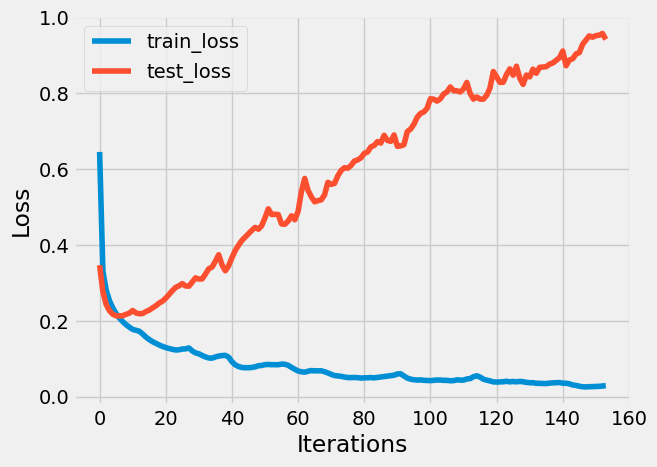

In [5]:
class Model(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        N_words = params['INPUT_WORDS_CNT']
        # N_variants = params['VARIANTS_CNT']
        N_features = params['TOTAL_WORD_FEATURES_CNT']

        # input is (N, N_words, N_features)
        # output is (N, N_words, )

        self.model = nn.Sequential(
            # nn.Flatten(2), 
            # (N, N_words, N_features + )
            # nn.TransformerEncoder(encoder_layer, num_layers=1),encoder = 
            nn.Linear(N_features, INTERNAL_EMBEDDING_SIZE),
            nn.BatchNorm1d(N_words),
            nn.ReLU(),
            
            xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config)),
            # xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config)),
            # xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config)),
            # xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config)),

            nn.Flatten(1), # (N, N_words* INTERNAL_EMBEDDING_SIZE)
            # nn.Tanh(),
            nn.Linear(N_words* INTERNAL_EMBEDDING_SIZE, params['TARGET_CLASSES_COUNT']),
            # nn.ReLU(),
            # nn.Linear(100, TARGET_CLASSES_COUNT),
            # nn.Tanh(),
            # nn.Tanhshrink(),
            # nn.Sigmoid(),
            # nn.ReLU(),
        )


    def forward(self, x):
        return self.model(x)

    # buffer_size = 0
    # for buffer in model.buffers():
    #     buffer_size += buffer.nelement() * buffer.element_size()
    # return (param_size + buffer_size) / 1024**2


# asdfadsfasfd

aa = {}
def train_model():
    model = Model()
    print(round(count_parameters(model), 3), "Mb of parameters")
    import importlib
    import trainer_mod
    importlib.reload(trainer_mod)
    Trainer = trainer_mod.Trainer

    model = torch.compile(model)
    optimizer = torch.optim.Adam(model.parameters(), 
                            lr=1e-3)
                            # betas=(0.5, 0.999))

    trainer = Trainer(model=model, 
                    # enable_chunking=True,
                    # loss=nn.MSELoss(),
                    loss=nn.CrossEntropyLoss(),
                    optimizer=optimizer,
                    scheduler=None,
                    # scheduler=ReduceLROnPlateau(optimizer, factor=0.2, threshold=1e-5, patience=50),
                    additional_losses={
                        # "accurancy": lambda trainer: {"accurancy": 
                        #    float(torch.mean(torch.abs(trainer.model(trainer.x_test) - trainer.y_test)).detach())
                        # },
                    })

    trainer.set_data(dataset)
    try:
        trainer.train(400, trial=None, log=True) # , chunk_size=680000,
    except KeyboardInterrupt:
        print("interrupted")
        # type, val, tb = sys.exc_info()
        # traceback.clear_frames(tb)
        pass
    trainer.plot_history(cutoff=0)
    return trainer
import os
# os.environ["CUDA_HOME"] = "/home/misha-sh/cuda"

trainer = train_model()
# run_proc(train_model)

In [5]:
trainer.model = torch.load("model.v1", map_location=torch.device('cuda:0'))

In [ ]:
Positional embedding должен быть около знака препинания, а не около начала

In [20]:
import __main__

for i in ["_", "__", "___", "____", "_____", "trainer", "model", "optimizer", "Out"] + \
         ["_" + str(j) for j in range(100)]:
    for j in [locals(), globals(), __main__.__dict__]:
        try:
            del j[i]
        except: pass
        for f in range(100):
            try:
                del j["_oh"][f]
            except:
                pass
import sys
try:
    sys.last_traceback.tb_next = None
except: pass

import objgraph
for i in objgraph.by_type('Trainer'):
    i.model = None
    i.x = None
    i.y = None
    i.optimizer = None
    i.x_train = None
    i.y_train = None
    i.x_test = None
    i.y_test = None
    i.dataset = None
    
import gc
# aa.clear()
gc.collect()
torch.cuda.empty_cache() 
1/0


ZeroDivisionError: division by zero

In [21]:
model = trainer.model.to('cpu:0')

from timeit import default_timer as timer
start = timer()
with torch.no_grad():
    trainer.model(trainer.dataset.x_test)
end = timer()
print(len(trainer.dataset.x_test) / (end - start) / 32, "words per sec")

_ = trainer.model.cuda()

2977.485641907047 words per sec


In [22]:
torch.save(trainer.model, "model.v1")

<AxesSubplot: >

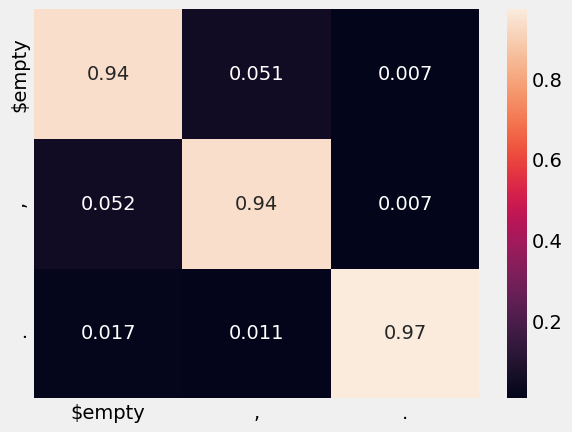

In [6]:
with torch.no_grad():
    trainer.model.eval()
    y_test_pred = trainer.model(trainer.dataset.x_test.to(trainer.device))
    _, y_pred_tags = torch.max(y_test_pred, dim = 1)
    y_pred = y_pred_tags.cpu().numpy()
    _, y_test_tags = torch.max(trainer.dataset.y_test, dim = 1)
    y_test = y_test_tags.cpu().numpy()
    
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred, normalize="true")).rename(
        columns=params['ID_TO_PUNCTUATION'], index=params['ID_TO_PUNCTUATION'])
sns.heatmap(confusion_matrix_df, annot=True)

In [15]:
morph.parse("Ивана Ивановича")

[Parse(word='ивана ивановича', tag=OpencorporaTag('NOUN,anim,masc,Patr sing,gent'), normal_form='ивана иванович', score=0.5, methods_stack=((FakeDictionary(), 'ивана ивановича', 26, 1), (KnownSuffixAnalyzer(min_word_length=4, score_multiplier=0.5), 'овича'))),
 Parse(word='ивана ивановича', tag=OpencorporaTag('NOUN,anim,masc,Patr sing,accs'), normal_form='ивана иванович', score=0.5, methods_stack=((FakeDictionary(), 'ивана ивановича', 26, 3), (KnownSuffixAnalyzer(min_word_length=4, score_multiplier=0.5), 'овича')))]

In [11]:
import shap
import scipy as sp
# https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Using%20custom%20functions%20and%20tokenizers.html
import dataset_builder
importlib.reload(dataset_builder)
trainer.model.eval()

import functools
@functools.lru_cache
def cached_word_features(tokens):
    return dataset_builder.get_word_features(tokens, params)

def inference(tokens_list):
    res = []
    features = torch.stack([
        torch.stack([cached_word_features(token) for token in tokens])
        for tokens in tokens_list])
    with torch.no_grad():
        model_pred = trainer.model(features.to(trainer.device))
        # _, val  = torch.max(model_pred, dim = 1)
        # res.append(val[0].item())
        outputs = model_pred.cpu().numpy()
        scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
        val = sp.special.logit(scores)
    return val
    # trainer.model

masker = shap.maskers.Text(dataset_builder.build_tokens, mask_token="UNDEF", collapse_mask_token=False, output_type="token_ids")

explainer = shap.Explainer(inference, masker, max_evals=100, output_names=["empty", ',', '.'])
# explainer = shap.explainers.Permutation(trainer.model, max_evals=3541)

for i in range(300, 450):
    text = dataset.texts_res[trainer.dataset.test_indices[i]]
    text_input = text.copy()
    del text_input[params['INPUT_WORDS_CNT_LEFT']]

    model_res = inference([text_input])[0]
    if np.argmax(model_res) == np.argmax(dataset.y_test[i].cpu().numpy()): 
        continue
    # if np.argmax(model_res) != 2: continue

    text = " ".join(text)
    text_input = " ".join(text_input)
    print("TARGET:", text)
    print("INPUT:", text_input)
    print("OUTPUT:", model_res)
    # print("OUTPUT:", params["ID_TO_PUNCTUATION"][model_res])
    shap_values = explainer([text_input])
    shap.plots.text(shap_values)
    print("=" * 100)
    print("=" * 100)

TARGET: . По сообщению ВВС , погиб один человек  #$empty#  и около 70 ранены PAD PAD PAD PAD
INPUT: . По сообщению ВВС , погиб один человек и около 70 ранены PAD PAD PAD PAD
OUTPUT: [ -1.2186204   1.2184156 -10.230125 ]


TARGET: силы заняли позиции на высотах южнее населенного пункта  #$empty#  Даргели и у перевала " Волчьи ворота "
INPUT: силы заняли позиции на высотах южнее населенного пункта Даргели и у перевала " Волчьи ворота "
OUTPUT: [-1.7067579 -3.7184432  1.5348765]


TARGET: пресс-центре еще раз подчеркнули , что части Минобороны  #$empty#  непосредственно в боевых действиях участия не принимают а
INPUT: пресс-центре еще раз подчеркнули , что части Минобороны непосредственно в боевых действиях участия не принимают а
OUTPUT: [ -1.9015193   1.9015127 -14.177442 ]


TARGET: требований их абазинский , черкесский и ряд других  #$empty#  проживающих в Карачаево-Черкесии народов " вынуждены будут приступить
INPUT: требований их абазинский , черкесский и ряд других проживающих в Карачаево-Черкесии народов " вынуждены будут приступить
OUTPUT: [ -4.3168287   4.315836  -11.256437 ]


TARGET: черкесский и ряд других проживающих в Карачаево-Черкесии народов  #$empty#  " вынуждены будут приступить к самостоятельному формированию органов
INPUT: черкесский и ряд других проживающих в Карачаево-Черкесии народов " вынуждены будут приступить к самостоятельному формированию органов
OUTPUT: [-0.4954317   0.39006644 -3.6600184 ]


In [ ]:
def full_text_inference():
    tokens = [dataset_builder.PAD_TOKEN] * params['INPUT_WORDS_CNT_LEFT'] + \
            dataset_builder.build_tokens(text, False)['input_ids'] + \
            [dataset_builder.PAD_TOKEN] * params['INPUT_WORDS_CNT_RIGHT']
    for pos in 
        for i in range(params["INPUT_WORDS_CNT_RIGHT"] + 1):
        input.append(PAD_TOKEN)
        output.append(NO_PUNCT)
    dataset_builder

In [19]:
text = 'PAD ' * 8 + 'Мама пришла , кот съел еду'+ ' PAD' * 7
text_input = text.split()
del text_input[params['INPUT_WORDS_CNT_LEFT']]

model_res = inference([text_input])[0]

text = " ".join(text)
text_input = " ".join(text_input)
print("TARGET:", text)
print("INPUT", text_input)
print("OUTPUT:", model_res)
# print("OUTPUT:", params["ID_TO_PUNCTUATION"][model_res])
shap_values = explainer([text_input])
shap.plots.text(shap_values)

TARGET: P A D   P A D   P A D   P A D   P A D   P A D   P A D   P A D   М а м а   п р и ш л а   ,   к о т   с ъ е л   е д у   P A D   P A D   P A D   P A D   P A D   P A D   P A D
INPUT PAD PAD PAD PAD PAD PAD PAD PAD Мама пришла кот съел еду PAD PAD PAD PAD PAD PAD PAD
OUTPUT: [  3.6143982  -3.615273  -10.711602 ]


In [ ]:
# chain[1] asdf
for elem in chain[1]:
    # if "trainer_mod.Trainer" in str(chain[1][elem]) and not isinstance(chain[1][elem], str)
    if chain[2] == chain[1][elem]:
        print(elem)

for elem in chain[2]:
    if "trainer_mod.Trainer" in str(chain[2][elem]) and not isinstance(chain[2][elem], str)
    # if chain[3] == chain[2][elem]:
        print(elem)

import torch.nn as nn
import torch
def ttest():
    model = nn.Linear(100 * 100, 1).to("cuda:0")
    try:
        for i in range(1000000000):
            pass
    except KeyboardInterrupt:
        print("wer")
        pass
    a = torch.rand(100).to('cuda:0')
    return model
model = ttest()

_oh


In [ ]:
inp = nn.Flatten(2)(input[:11])

config = xFormerEncoderConfig(**encoder_config)

encoder = xFormerEncoderBlock(config)

#  Test out with dummy inputs
x = (torch.rand((10, N_words, N_variants * N_features))).abs().to(torch.float32)
y = encoder(x) # (x, x, x)
print(x.shape, y.shape)

# a = nn.TransformerEncoderLayer(d_model=N_variants *N_features,
#                                nhead=4, dim_feedforward=10, batch_first=True)
# inp.shape, a(inp).shape, count_parameters(a)

In [ ]:
aa

{}

In [ ]:
%reset_selective trainer

In [ ]:

objgraph.find_backref_chain(objgraph.by_type('Trainer')[0], objgraph.is_proper_module)[-2]

SyntaxError: cannot delete function call (3434817761.py, line 2)

In [13]:
# import objgraph
# objgraph.show_backrefs(objgraph.by_type('Trainer'), 10)

In [ ]:
from xformers.factory import xFormerEncoderBlock, xFormerEncoderConfig
N_words = INPUT_WORDS_CNT
N_variants = VARIANTS_CNT
N_features = FEATURES_CNT

INTERNAL_EMBEDDING_SIZE = 4

encoder_config = {
    "dim_model": INTERNAL_EMBEDDING_SIZE, #N_variants * N_features,
    "residual_norm_style": "pre",  # Optional, pre/post
    "position_encoding_config": {
        "name": "sine",  # whatever position encodinhg makes sense
        # "dim_model": VARIANTS_CNT * N_features,
    },
    "multi_head_config": {
        "num_heads": 4,
        "residual_dropout": 0,
        "attention": {
            "name": "scaled_dot_product", #m fourier_mix, "linformer" scaled_dot_product,  # whatever attention mechanism
            "dropout": 0, # linformer
            "seq_len": N_words, # linformer, scaled_dot_product
            "to_seq_len": N_words, # scaled_dot_product
        },
    },
    "feedforward_config": {
        "name": "MLP",
        "dropout": 0,
        "activation": "relu",
        "hidden_layer_multiplier": 1,
    },
}
# print(INTERNAL_EMBEDDING_SIZE,
#         round(count_parameters(nn.Linear(N_variants * N_features, INTERNAL_EMBEDDING_SIZE)), 4),
#         round(count_parameters(xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config))), 4), "x2 ",
#         round(count_parameters(nn.Linear(N_words* INTERNAL_EMBEDDING_SIZE, TARGET_CLASSES_COUNT)), 4),
#         "=",
#         round(count_parameters(Model()), 4))


In [ ]:
y_test, y_pred

(array([0, 2, 2, ..., 2, 0, 0]), array([0, 2, 2, ..., 1, 0, 0]))

In [ ]:
with torch.no_grad():
    model.eval()
    model.to

In [ ]:
y_test.shape, y_pred_list.shape

((167122, 3), (1, 167122))

In [ ]:
trainer.y_train

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0.])

In [ ]:
# scaler = GradScaler()

# for input, target in data:
#     with torch.autocast(device_type='cuda'):
#         output = model(input)
#         loss = loss_fn(output, target)
#     scaler.scale(loss).backward()
#     scaler.step(optimizer)
#     scaler.update()


In [ ]:


# import sys,functools, traceback
# def gpu_mem_restore(func):
#     "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
#     @functools.wraps(func)
#     def wrapper(*args, **kwargs):
#         try:
#             return func(*args, **kwargs)
#         except:
#             type, val, tb = sys.exc_info()
#             traceback.clear_frames(tb)
#             raise type(val).with_traceback(tb) from None
#     return wrapper

# @gpu_mem_restore